Computer Exercise 1

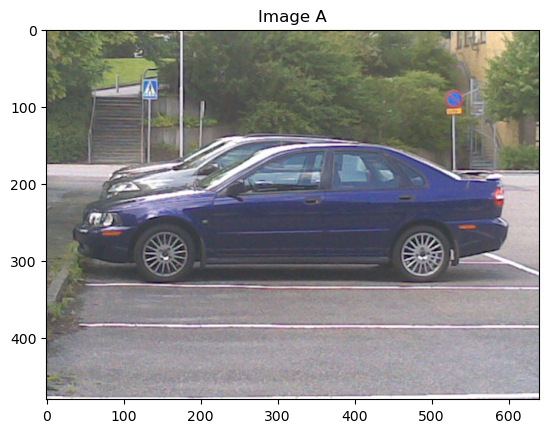

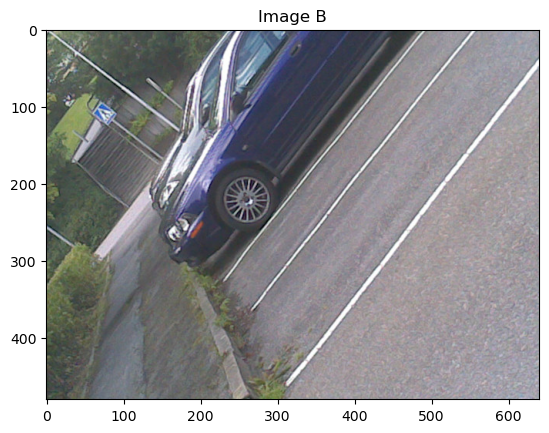

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load images (OpenCV loads images as BGR by default)
imgA = cv2.imread('a.jpg')   # or your own image
imgB = cv2.imread('b.jpg')

# Convert from BGR to RGB for plotting
imgA_rgb = cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB)
imgB_rgb = cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB)

# Show the images
plt.figure(); plt.imshow(imgA_rgb); plt.title('Image A')
plt.figure(); plt.imshow(imgB_rgb); plt.title('Image B')
plt.show()


In [ ]:
# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kpA, descA = sift.detectAndCompute(imgA, None)
kpB, descB = sift.detectAndCompute(imgB, None)

# Use BFMatcher or FLANN to match descriptors
bf = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descA, descB)

# Sort matches by distance (optional, helps in debugging)
matches = sorted(matches, key=lambda x: x.distance)

print("Number of SIFT features in A:", len(kpA))
print("Number of SIFT features in B:", len(kpB))
print("Number of matches:       ", len(matches))


Number of SIFT features in A: 1521
Number of SIFT features in B: 1632
Number of matches:        542


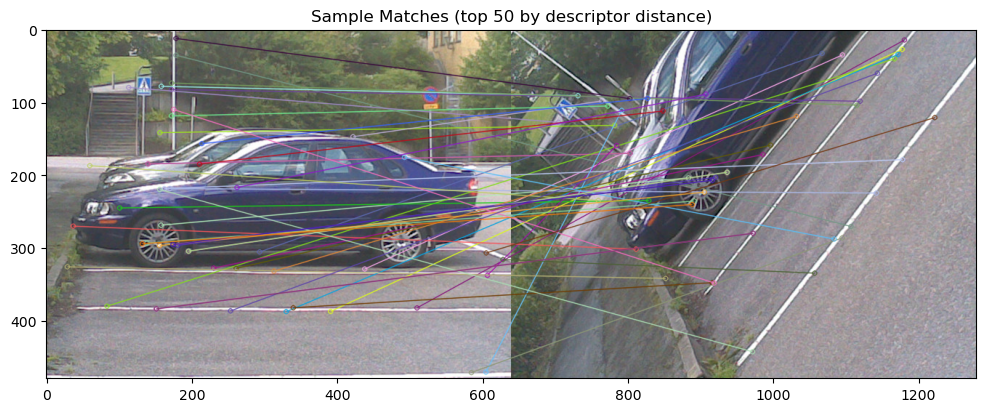

In [5]:
match_img = cv2.drawMatches(
    imgA_rgb, kpA,
    imgB_rgb, kpB,
    matches[:50],  # show top 50
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(12,6))
plt.imshow(match_img)
plt.title('Sample Matches (top 50 by descriptor distance)')
plt.show()


In [7]:
ptsA = []
ptsB = []

for m in matches:
    # queryIdx -> index in A, trainIdx -> index in B
    ptsA.append(kpA[m.queryIdx].pt)  # (x, y) in A
    ptsB.append(kpB[m.trainIdx].pt)  # (x, y) in B

ptsA = np.array(ptsA, dtype=np.float32)
ptsB = np.array(ptsB, dtype=np.float32)
H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)
# mask is a vector with 1/0 indicating inliers/outliers

inliers_count = np.sum(mask)
print("Number of inliers: ", inliers_count, "out of", len(matches))


Number of inliers:  264 out of 542


In [10]:
def dlt_homography(ptsA_4, ptsB_4):
    """
    ptsA_4, ptsB_4: shape (4,2) each
    Return: 3x3 homography (numpy array)
    """
    # Build the linear system for 4 correspondences
    # 8 equations in total
    A = []
    for i in range(4):
        xA, yA = ptsA_4[i]
        xB, yB = ptsB_4[i]
        A.append([ xA,  yA, 1,   0,   0,  0, -xB*xA, -xB*yA, -xB])
        A.append([  0,   0,  0,  xA,  yA, 1, -yB*xA, -yB*yA, -yB])
    A = np.array(A, dtype=np.float32)

    # Solve via SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1,:]      # last row
    H = h.reshape(3,3)
    # Normalize so that H[2,2] = 1
    H = H / H[2,2]
    return H

def ransac_homography(ptsA, ptsB, num_iterations=1000, threshold=5.0):
    best_inliers = 0
    best_H = None
    N = ptsA.shape[0]
    
    for _ in range(num_iterations):
        # sample 4 random indices
        idxs = np.random.choice(N, 4, replace=False)
        ptsA_4 = ptsA[idxs]
        ptsB_4 = ptsB[idxs]
        
        # estimate homography
        H_candidate = dlt_homography(ptsA_4, ptsB_4)
        
        # compute inliers
        # transform all ptsA with H_candidate
        ones = np.ones((N,1), dtype=np.float32)
        ptsA_hom = np.hstack([ptsA, ones])  # Nx3
        projB = (H_candidate @ ptsA_hom.T).T  # Nx3
        projB /= projB[:,[2]]                # normalize w.r.t third coordinate
        
        # distances
        diff = ptsB - projB[:,0:2]  # Nx2
        dist_sq = np.sum(diff**2, axis=1)
        inliers = np.count_nonzero(dist_sq < threshold**2)
        
        # update best
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H_candidate
    
    return best_H, best_inliers

H, inliers_count = ransac_homography(ptsA, ptsB, num_iterations=2000, threshold=5.0)
print("RANSAC inliers:", inliers_count, "/", len(ptsA))


RANSAC inliers: 273 / 542


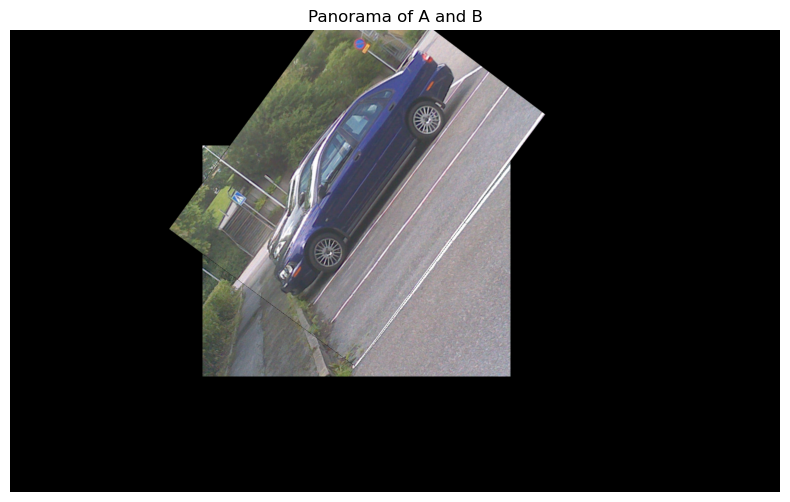

In [ ]:
# Suppose we want to warp imgA into imgB's coordinate system
hB, wB, _ = imgB.shape

# Create an even larger canvas for a zoom-out effect
result_width = int(wB * 2.5)  # Increase width significantly
result_height = int(hB * 2.0)  # Increase height significantly

# Translation matrix to shift images towards the center of the enlarged canvas
translation_matrix = np.array([
    [1, 0, result_width // 4],   # Shift image A rightward
    [0, 1, result_height // 4],  # Shift image A downward
    [0, 0, 1]
])

# Adjust the homography to include the translation (this "zooms out")
H_translated = translation_matrix @ H

# Warp imgA
warpedA = cv2.warpPerspective(imgA, H_translated, (result_width, result_height))

# Create a blank canvas for imgB
canvasB = np.zeros((result_height, result_width, 3), dtype=np.uint8)

# Insert imgB in the center of the enlarged canvas
canvasB[result_height // 4 : result_height // 4 + hB,
        result_width // 4 : result_width // 4 + wB] = imgB

# Blending
mask = (warpedA > 0)
canvasB[mask] = warpedA[mask]

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(canvasB, cv2.COLOR_BGR2RGB))
plt.title('Panorama of A and B')
plt.axis('off')
plt.show()
